<a href="https://colab.research.google.com/github/Hyeseong0317/Pytorch_Capstone_Design/blob/main/pytorch_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install torchvision

In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy

In [7]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(400),                         
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(400), 
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(400),                        
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

In [9]:
data_dir = '/content/drive/Shareddrives/8:1:1/OCT2017(8:1:1)'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in ['train', 'val', 'test']}


train_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=110,
                                             shuffle=True, drop_last=True, num_workers=2)
                    for x in ['train']}

val_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=14,
                                             shuffle=True, drop_last=True, num_workers=2)
                    for x in ['val']}                   

test_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=14,
                                             shuffle=True, drop_last=True, num_workers=2)
                    for x in ['test']}



dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


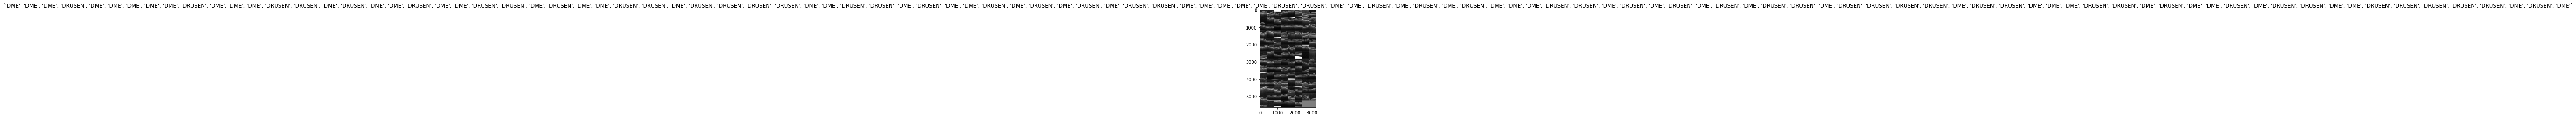

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(train_dataloader['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
import torch
import torch.nn as nn

inputs = torch.Tensor(1, 1, 400, 400)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([1, 1, 400, 400])


In [14]:
conv1 = nn.Conv2d(1, 32, 3, padding=1)
print(conv1)

conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
print(conv2)

pool = nn.MaxPool2d(2)
print(pool)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [15]:
out = conv1(inputs)
print(out.shape)

out = conv2(out)
print(out.shape)

out = pool(out)
print(out.shape)

out = pool(out)
print(out.shape)

torch.Size([1, 32, 400, 400])
torch.Size([1, 64, 400, 400])
torch.Size([1, 64, 200, 200])
torch.Size([1, 64, 100, 100])


In [16]:
out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([1, 640000])


In [17]:
model = torch.nn.Sequential(
    conv1,
    torch.nn.ReLU(),
    pool,
    conv2,
    torch.nn.ReLU(),
    pool,
    torch.nn.Linear(100 * 100 * 64, 4, bias=True) # 최종 output 400*400 (Maxpooling) -> 200*200 (Maxpooling) -> 100*100 pixels, 채널수 1 -> 32 -> 64, 즉 100*100 pixels, 64채널의 output과 4개의 분류(CNV,DME, DRUSEN, NORMAL)
).to(device)

In [18]:
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Linear(in_features=640000, out_features=4, bias=True)
)

In [35]:
training_epochs = 1
learning_rate = 0.001
total_batch = len(train_dataloader['train'])
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 149


In [37]:
len(val_dataloader['val'])

603

In [38]:
len(test_dataloader['test'])

590

In [22]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)